In [1]:
import os
import sys

sys.path.append(os.path.abspath("..")) # make src available as a package

In [2]:
SEED = int(os.getenv("SEED", 42))

# import random
# import numpy as np
# import torch
# import datasets

# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.use_deterministic_algorithms(True)
# torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


# TODO: check if this was all?
# TODO: what about CUDNN flags?

# 1. Dataset Preparation

In [3]:
from src.data import mMARCO

# only used for testing here, use the dataloaders otherwise
mmarco = mMARCO(seed=SEED, shuffle_buffer_size=64, shuffle=False)
print(mmarco._data.info)

for sample in mmarco:
    print(sample)
    break

DatasetInfo(description='', citation='', homepage='', license='', features={'query': Value('string'), 'positive': Value('string'), 'negative': Value('string')}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='mmarco', config_name='default', version=0.0.0, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)
{'query': 'is a little caffeine ok during pregnancy', 'positive': 'We donâ\x80\x99t know a lot about the effects of caffeine during pregnancy on you and your baby. So itâ\x80\x99s best to limit the amount you get each day. If youâ\x80\x99re pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.', 'negative': 'It is generally safe for pregnant women to eat chocolate because studies have shown to prove certain benefits of eating chocolate during pregnancy. However, pregnant women should ensure their 

# 2. Training

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for Apple's Metal (MPS) backend / framework
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Using device: {device}")

Using device: cuda


Pointwise cross-encoders are supposed to output a class label (e.g., *relevant*
or *not-relevant*) or a relevance score (e.g., from 0 to 1). Now, this model
returns raw logits (practically a relevance score). However, the dataset does
not have any gold labels, which could be used to compute a loss.

Fortunately, the `(query, positive, negative)` triplets can easily be framed as
such:
- `(query, positive)=1` now means *relevant*
- `(query, negative)=0` now means *not-relevant*

Et voilà, this can be used for trainig.

During training, we have to apply sigmoid to the raw logits to get a binary
score though. However, during inference, we want the raw logits to build a
sorted ranking.

NOTE: There are quite a few CEL functions...
- `nn.CrossEntropyLoss` 
  - **use case**: multi-class classification
  - **input**: raw logits for each class (`input`), and the target class indices (`target`).
- `nn.BCELoss`
  - **use case**: binary classification or multi-label classification (independent classes)
  - **input**: probabilities (so sigmoid must already be applied) and the target class indices (`target`).
- `nn.BCEWithLogitsLoss` ← ✅
  - **use case**: binary classification or multi-label classification (independent classes)
  - **input**: raw logits (so sigmoid is applied internally), and the target class indices (`target`).


### Hyperparameters

In [ ]:
from src.models import CrossEncoderBERT
import torch.optim as optim
import torch.nn as nn

padding = "longest"
max_length = 512
batch_size = 32
model = CrossEncoderBERT(
    # enable_gradient_checkpointing=True,
)
criterion = nn.BCEWithLogitsLoss(reduction="none") # → individual loss per sample is stored
# learning_rate = 2e-5
learning_rate = 1e-5
epochs = 3
# epochs = 5
samples_per_epoch = 300_000
# NOTE: has L2 regularization built-in
# default == 0.01 == 1e-2
weight_decay = 1e-3 
optimizer = optim.AdamW([
    {"params": model.bert.parameters(), "lr": 1e-6},
    {"params": model.classifier.parameters(), "lr": learning_rate}, # slighly higher LR for the classifier
], lr=learning_rate, weight_decay=weight_decay)

# NOTE: 1.0 is common for BERT fine-tuning; after frequent clipping,
# I experimented with increasing this
max_grad_norm = 1.25

train_dl, val_dl, test_dl = mmarco.as_dataloaders(seed=SEED, batch_size=batch_size, max_samples_per_split=samples_per_epoch)

### Training Loop

CV (coefficient of variance) interpretation:
- < 10-20%: low variance (stable training)
- \> 20-40%: high variance (possible training instability)

NOTE: When the loss becomes stable, even small fluctuations can lead to high CV,
rendering it less useful.

Standard Deviation interpretation: 
- stable losses are generally within ±5% of the mean

Good validation loss (CEL):

**NOTE: Some fluctuation in batch loss is expected, especially during early training!**

In [6]:
from typing import cast
from transformers import BatchEncoding
from src.data.mmarco import mMARCOBatch
from IPython.display import display
import torch.nn as nn
from src.utils.widgets import Label, Counter, progress_widgets, update_progress, update_loss
from src.utils.stats import Stats
import ipywidgets


# convenience function to tokenize a batch
def tokenize(batch: mMARCOBatch):
    return model.tokenize(
        batch["queries"],  # pyright: ignore[reportGeneralTypeIssues]
        batch["candidates"],  # pyright: ignore[reportGeneralTypeIssues]
        padding=padding,
        max_length=max_length,
    ).to(device)

# convenience function to unpack the BatchEncoding for the model's forward
def feed(input: BatchEncoding):
    return input["input_ids"], input["attention_mask"], input["token_type_ids"],  # type: ignore

stats = Stats()
widgets = progress_widgets(epochs)
progress_widget = widgets["progress"]
training_loss_widget = widgets["train_loss"]
val_loss_widget = widgets["val_loss"]

# print stats and display widgets
time_label = Label(f"Start: {stats.start.strftime('%H:%M:%S')}" + " Stop: {value}", show=False)
# used for both training and validation ...
batch_counter = Counter("Batches: {value}", show=False) # batches seen per epoch
iter_counter = Counter("Iterations: {value}", show=False) # samples seen per epoch

# Mean loss per epoch (NO rolling window)
train_mean_loss_label = Label("L\u0305: {value:.4f}", show=False) # Mean Loss per epoch
val_mean_loss_label = Label("L\u0305: {value:.4f}", show=False) # Mean Loss per epoch

# Standard Deviation per epoch (rolling window for training)
train_deviation_label = Label("σ: {value:.4f}", show=False)
val_deviation_label = Label("σ: {value:.4f}", show=False)

# Coefficient of Variation per epoch (rolling window for training)
train_cv_label = Label("CV: {value:.2f}%", show=False, transform=lambda x: x * 100) 
val_cv_label = Label("CV: {value:.2f}%", show=False, transform=lambda x: x * 100)

display(ipywidgets.VBox([
    ipywidgets.HBox([time_label.widget]),
    ipywidgets.HBox([progress_widget, batch_counter.widget, iter_counter.widget]),
    ipywidgets.HBox([training_loss_widget, train_mean_loss_label.widget, train_deviation_label.widget, train_cv_label.widget]),
    ipywidgets.HBox([val_loss_widget, val_mean_loss_label.widget, val_deviation_label.widget, val_cv_label.widget])
]))

# GPU => prefer bfloat16, so no GradScaler needed
# CPU/MPS => stick to FP32 (no autocast)
dtype = torch.bfloat16 if device.type == "cuda" else torch.float32
autocast_enabled = device.type == "cuda" # assume GPU is Ampere or later
model.to(device)

# --- gradient norm tracking (to detect exploding gradients) ---
train_grad_steps: list[int] = []    # global step index across epochs
train_grad_epochs: list[int] = []   # epoch index for each step
train_grad_norms: list[float] = []  # total grad norm BEFORE clipping
train_grad_clipped: list[bool] = [] # whether this step required clipping
global_step = 0

for epoch in range(epochs):

    # --- training loop ---
    model.train()
    for idx, batch in enumerate(train_dl):
        batch = cast(mMARCOBatch, batch)
        num_samples = len(batch["queries"])
        input = tokenize(batch)

        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=dtype, enabled=autocast_enabled):
            logits = model(*feed(input)).squeeze(-1)
            losses = criterion(logits, batch["labels"].float().to(device))
            
        loss = losses.mean()
        loss.backward()

        # clip_grad_norm_ returns the total norm BEFORE clipping – perfect for monitoring
        total_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        try:
            total_norm_float = float(total_norm)
        except Exception:
            # Fallback in rare cases
            total_norm_float = float(total_norm.item()) if hasattr(total_norm, "item") else float("nan")

        optimizer.step()

        # Track gradient norm time series
        train_grad_steps.append(global_step)
        train_grad_epochs.append(epoch)
        train_grad_norms.append(total_norm_float)
        train_grad_clipped.append(total_norm_float > max_grad_norm)
        global_step += 1

        # values for UI
        mean_loss = loss.item()

        # - update stats - (ensure CPU list even when running on GPU)
        stats.collect("train", epoch, idx, losses.detach().float().cpu().tolist())
        # - update widgets -
        batch_counter.inc()
        iter_counter.update(num_samples)
        update_loss(mean_loss, training_loss_widget, "Train")
        train_mean_loss_label.set(stats.mean("train", epoch, window=100))
        train_deviation_label.set(stats.std("train", epoch, window=100))
        train_cv_label.set(stats.CV("train", epoch, window=5000))
    

    # after each epoch, reset some widgets / counters
    batch_counter.clear()
    iter_counter.clear()

    # --- validation loop ---
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_dl):
            batch = cast(mMARCOBatch, batch)    
            num_samples = len(batch["queries"])
            input = tokenize(batch)
            logits = model(*feed(input)).squeeze(-1)
            losses = criterion(logits, batch["labels"].float().to(device))

            # - update stats -
            stats.collect("val", epoch, idx, losses.detach().float().cpu().tolist())
            # - update widgets -
            batch_counter.inc()
            iter_counter.update(num_samples)
            
            

            update_loss(losses.mean().item(), val_loss_widget, "Val")
            val_mean_loss_label.set(stats.mean("val", epoch, window=100))
            val_deviation_label.set(stats.std("val", epoch, window=100))
            val_cv_label.set(stats.CV("val", epoch, window=5000))


    tr_m, tr_s = stats.mean("train", epoch, window=0), stats.std("train", epoch, window=0)
    train_samples = sum(len(b) for b in stats.train_losses[epoch])
    va_m, va_s = stats.mean("val", epoch, window=0), stats.std("val", epoch, window=0)
    val_samples = sum(len(b) for b in stats.val_losses[epoch])
    print(f"Epoch {epoch} | Train: {tr_m:.4f} ± {tr_s:.4f} (n={train_samples}) | Val: {va_m:.4f} ± {va_s:.4f} (n={val_samples})")

    update_progress(epoch, epochs, progress_widget)
    batch_counter.clear()
    iter_counter.clear()
            
    
model.eval()
stats.stop()
time_label.set(f"{stats.end.strftime('%H:%M:%S')} ({(stats.elapsed/60):.1f}min)") # pyright: ignore[reportOptionalOperand, reportOptionalMemberAccess]

Epoch 0 | Train: 0.2737 ± 0.5666 (n=300000) | Val: 0.2211 ± 0.6423 (n=300000)
Epoch 1 | Train: 0.2041 ± 0.5682 (n=300000) | Val: 0.2095 ± 0.6739 (n=300000)
Epoch 1 | Train: 0.2041 ± 0.5682 (n=300000) | Val: 0.2095 ± 0.6739 (n=300000)
Epoch 2 | Train: 0.1816 ± 0.5610 (n=300000) | Val: 0.2051 ± 0.6852 (n=300000)


After the training (and validation) cycles are done,
the reamaining test set is used to report the final
performance.

In [7]:
model.eval()
with torch.no_grad():
    for batch in test_dl:
        ...

### Saving The Model

In [8]:
stop_rfc3339 = stats.end.strftime("%Y-%m-%dT%H:%M:%S%Z")  # pyright: ignore[reportOptionalMemberAccess]

In [9]:
filename = f"cross-encoder_pointwise_{stop_rfc3339}.pth"
torch.save(model.state_dict(), filename)

# and later load with:
# model = CrossEncoderBERT()
# model.load_state_dict(torch.load("model_state.pth"))
# model.eval()

### Plotting & Detailed Trainings Run Analysis

NOTE: NaNs have occured during training, I believe it's likely
due to gradient clipping = loss becomes numberically unstable.

TODO: To prevent runtime errors when using the model later on,
the `Stats` class should ideally fix this by removing NaNs
from the recorded losses.

Epoch 01 | Train: 0.2737 ± 0.5666 (n=300000) | Val: 0.2211 ± 0.6423 (n=300000)
Epoch 02 | Train: 0.2041 ± 0.5682 (n=300000) | Val: 0.2095 ± 0.6739 (n=300000)
Epoch 03 | Train: 0.1816 ± 0.5610 (n=300000) | Val: 0.2051 ± 0.6852 (n=300000)


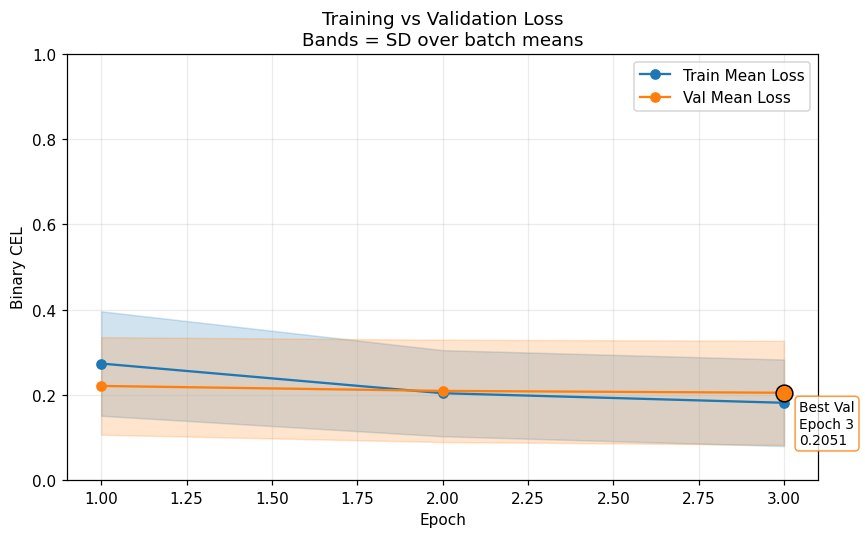

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt


def _summarize_split(split: str):
    """Summarize per-epoch stats using the new Stats API (sample-level)."""
    means: list[float] = []
    stds: list[float] = []
    counts: list[int] = []

    if split == "train":
        losses_ref = stats.train_losses
    elif split == "val":
        losses_ref = stats.val_losses
    elif split == "test":
        losses_ref = stats.test_losses
    else:
        losses_ref = []

    for epoch in range(len(losses_ref)):
        means.append(stats.mean(split, epoch, window=0))
        stds.append(stats.std(split, epoch, window=0))
        # count samples in this epoch (sum over batches)
        counts.append(sum(len(b) for b in losses_ref[epoch]))

    return means, stds, counts


def _batch_level_std(split: str):
    """Compute per-epoch standard deviation across batch means and number of batches.

    This better matches uncertainty around the epoch mean (which aggregates batches)
    and avoids vanishing bands when using huge per-sample counts.
    """
    if split == "train":
        losses_ref = stats.train_losses
    elif split == "val":
        losses_ref = stats.val_losses
    elif split == "test":
        losses_ref = stats.test_losses
    else:
        losses_ref = []

    batch_std_per_epoch: list[float] = []
    n_batches_per_epoch: list[int] = []
    for epoch in range(len(losses_ref)):
        batch_means: list[float] = []
        for batch_losses in losses_ref[epoch]:
            if len(batch_losses) > 0:
                batch_means.append(float(np.mean(np.asarray(batch_losses, dtype=float))))
        nb = len(batch_means)
        if nb == 0:
            batch_std_per_epoch.append(float("nan"))
            n_batches_per_epoch.append(0)
        else:
            arr = np.asarray(batch_means, dtype=float)
            batch_std_per_epoch.append(float(np.std(arr, ddof=0)))  # population std of batch means
            n_batches_per_epoch.append(nb)
    return batch_std_per_epoch, n_batches_per_epoch


def _pad_to_n(xs: list[float], n: int, pad_value: float = float("nan")) -> list[float]:
    return xs + [pad_value] * max(0, n - len(xs))


def _pad_to_n_int(xs: list[int], n: int, pad_value: int = 0) -> list[int]:
    return xs + [pad_value] * max(0, n - len(xs))


# Summaries per split (sample-level means for plotting the lines)
train_means, train_stds, train_counts = _summarize_split("train")
val_means_raw, val_stds_raw, val_counts_raw = _summarize_split("val")

# Batch-level std (for uncertainty bands)
train_batch_std, train_n_batches = _batch_level_std("train")
val_batch_std_raw, val_n_batches_raw = _batch_level_std("val")

# Align validation arrays to the number of training epochs (for plotting on one axis)
num_epochs = len(train_means)
val_means = _pad_to_n(val_means_raw, num_epochs)
val_stds = _pad_to_n(val_stds_raw, num_epochs)
val_counts = _pad_to_n_int(val_counts_raw, num_epochs)
val_batch_std = _pad_to_n(val_batch_std_raw, num_epochs)
val_n_batches = _pad_to_n_int(val_n_batches_raw, num_epochs)

# Choose band mode: 'batch_ci95' | 'batch_sem' | 'batch_sd' | 'sample_sem' | 'sample_sd'
BAND_MODE = 'batch_sd'  # default to clearly visible bands

# Convert to numpy for vectorized math
train_means_arr = np.array(train_means, dtype=float)
val_means_arr = np.array(val_means, dtype=float)
train_std_arr = np.array(train_stds, dtype=float)
val_std_arr = np.array(val_stds, dtype=float)
train_counts_arr = np.array(train_counts, dtype=float)
val_counts_arr = np.array(val_counts, dtype=float)
train_batch_std_arr = np.array(train_batch_std, dtype=float)
val_batch_std_arr = np.array(val_batch_std, dtype=float)
train_n_batches_arr = np.array(train_n_batches, dtype=float)
val_n_batches_arr = np.array(val_n_batches, dtype=float)

# Determine band scales
if BAND_MODE == 'batch_ci95':
    train_scale = np.where(train_n_batches_arr > 0, 1.96 * train_batch_std_arr / np.sqrt(train_n_batches_arr), np.nan)
    val_scale = np.where(val_n_batches_arr > 0, 1.96 * val_batch_std_arr / np.sqrt(val_n_batches_arr), np.nan)
elif BAND_MODE == 'batch_sem':
    train_scale = np.where(train_n_batches_arr > 0, train_batch_std_arr / np.sqrt(train_n_batches_arr), np.nan)
    val_scale = np.where(val_n_batches_arr > 0, val_batch_std_arr / np.sqrt(val_n_batches_arr), np.nan)
elif BAND_MODE == 'batch_sd':
    train_scale = train_batch_std_arr
    val_scale = val_batch_std_arr
elif BAND_MODE == 'sample_sem':
    train_scale = np.where(train_counts_arr > 0, train_std_arr / np.sqrt(train_counts_arr), np.nan)
    val_scale = np.where(val_counts_arr > 0, val_std_arr / np.sqrt(val_counts_arr), np.nan)
else:  # 'sample_sd'
    train_scale = train_std_arr
    val_scale = val_std_arr

# Compute bands and clip to [0, 1] range for visibility with fixed y-limits
train_upper = np.clip(train_means_arr + train_scale, 0.0, 1.0)
train_lower = np.clip(train_means_arr - train_scale, 0.0, 1.0)
val_upper = np.clip(val_means_arr + val_scale, 0.0, 1.0)
val_lower = np.clip(val_means_arr - val_scale, 0.0, 1.0)

epochs_axis = np.arange(1, num_epochs + 1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=110)

# Plot mean loss per epoch
ax.plot(epochs_axis, train_means_arr, marker='o', label='Train Mean Loss', color='C0')
ax.plot(epochs_axis, val_means_arr, marker='o', label='Val Mean Loss', color='C1')

# Bands around the mean (add edge outline for visibility)
ax.fill_between(epochs_axis, train_lower, train_upper, color='C0', alpha=0.20, linewidth=1.0, edgecolor='C0', zorder=1)
ax.fill_between(epochs_axis, val_lower, val_upper, color='C1', alpha=0.20, linewidth=1.0, edgecolor='C1', zorder=1)

# Highlight best (lowest) validation epoch if available
if any(not math.isnan(v) for v in val_means_arr):
    best_epoch_idx = int(np.nanargmin(val_means_arr))
    ax.scatter(epochs_axis[best_epoch_idx], val_means_arr[best_epoch_idx], s=120, color='C1', edgecolor='k', zorder=5)
    ax.annotate(
        f"Best Val\nEpoch {best_epoch_idx+1}\n{val_means_arr[best_epoch_idx]:.4f}",
        (epochs_axis[best_epoch_idx], val_means_arr[best_epoch_idx]),
        textcoords="offset points", xytext=(10, -5), ha='left', va='top', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='C1', alpha=0.8)
    )

ax.set_xlabel('Epoch')
ax.set_ylabel('Binary CEL')
subtitle = {
    'batch_ci95': 'Bands = 95% CI over batch means',
    'batch_sem': 'Bands = SEM over batch means',
    'batch_sd': 'Bands = SD over batch means',
    'sample_sem': 'Bands = SEM over samples',
    'sample_sd': 'Bands = SD over samples',
}[BAND_MODE]
ax.set_title(f'Training vs Validation Loss\n{subtitle}')
ax.grid(True, alpha=0.25)
ax.legend()
ax.margins(x=0.05)
ax.set_ylim(0.0, 1.0)
plt.tight_layout()

# Structured summary printout (still reports sample-level std)
for i in range(num_epochs):
    tr_m = train_means[i]
    tr_s = train_stds[i]
    tr_c = train_counts[i]
    va_m = val_means[i]
    va_s = val_stds[i]
    va_c = val_counts[i]
    print(f"Epoch {i+1:02d} | Train: {tr_m:.4f} ± {tr_s:.4f} (n={tr_c}) | Val: {va_m:.4f} ± {va_s:.4f} (n={va_c})")

plt.savefig(f"training_validation_loss_{stop_rfc3339}.png", dpi=200)
plt.show()

During initial training, I experienced fluctuating losses and overfitting.
To detect exploding gradients, plot the gradient norms as well.

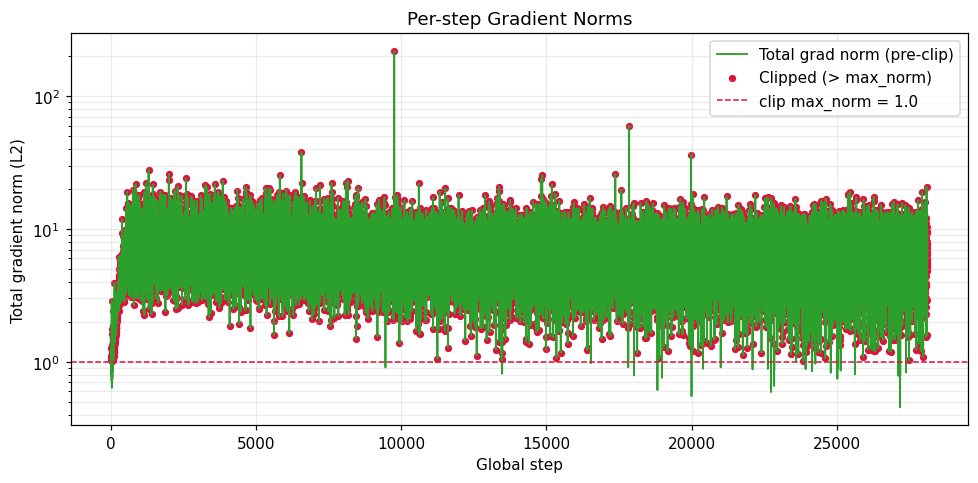

Recent 200 steps — median: 6.718, p95: 11.713
Gradient norms look stable in the recent window.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy for convenience
grad_steps = np.array(train_grad_steps, dtype=float) if 'train_grad_steps' in globals() else np.array([])
grad_norms = np.array(train_grad_norms, dtype=float) if 'train_grad_norms' in globals() else np.array([])
grad_clipped = np.array(train_grad_clipped, dtype=bool) if 'train_grad_clipped' in globals() else np.array([])

if grad_steps.size == 0:
    print("No gradient norm data collected. Run the training cell first.")
else:
    fig, ax = plt.subplots(figsize=(9, 4.5), dpi=110)
    ax.plot(grad_steps, grad_norms, color='C2', linewidth=1.2, label='Total grad norm (pre-clip)')
    # Highlight steps that exceeded the clip threshold
    if grad_clipped.size > 0 and grad_clipped.any():
        ax.scatter(grad_steps[grad_clipped], grad_norms[grad_clipped], s=14, color='crimson', label='Clipped (> max_norm)')
    # Horizontal line at the clipping threshold used in training
    ax.axhline(y=max_grad_norm, color='crimson', linestyle='--', linewidth=1.0, label=f'clip max_norm = {max_grad_norm}')
    ax.set_title('Per-step Gradient Norms')
    ax.set_xlabel('Global step')
    ax.set_ylabel('Total gradient norm (L2)')
    ax.set_yscale('log')  # norms can span orders of magnitude
    ax.grid(True, which='both', alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"gradient_norms_{stop_rfc3339}.png", dpi=200)
    plt.show()

    # Simple heuristic to flag potential exploding gradients
    if np.isfinite(grad_norms).any():
        last_k = 200 if grad_norms.size >= 200 else grad_norms.size
        if last_k > 0:
            recent = grad_norms[-last_k:]
            median_recent = float(np.median(recent))
            p95_recent = float(np.percentile(recent, 95))
            print(f"Recent {last_k} steps — median: {median_recent:.3f}, p95: {p95_recent:.3f}")
            if (recent > (10.0 * median_recent)).mean() > 0.05 or p95_recent > (5.0 * median_recent):
                print("Warning: Gradient norms show spikes consistent with exploding gradients.")
            else:
                print("Gradient norms look stable in the recent window.")



# 3. Evaluation



If passage reranking is treated as a binary classification task
(*»is this passage relevant to the query or not?«*), then
- **Precision** →
- **Recall** →

However, in ranking, the end goal is to rank the top-k passages 


For ranking in general, IR provides 


Metrics:
- MRR (Mean Reciprocal Rank)
- nDCG@k (Normalized Discounted Cumulative Gain at k)
- MAP (Mean Average Precision)
- Recall@k (or Hit@k)

In [12]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    # TODO: also perform accuracy and other metrics

# 4. Inference

In [13]:
def rank(query: str, candidates: list[str]) -> list[tuple[str, float]]:
    model.eval()
    inputs = model.tokenize([query]*len(candidates), list(candidates)).to(device)
    with torch.no_grad():
        logits = model.forward(
            input_ids=inputs["input_ids"],  # type: ignore
            attention_mask=inputs["attention_mask"],  # type: ignore
            token_type_ids=inputs["token_type_ids"],  # type: ignore
        )
    scores = torch.sigmoid(logits).squeeze(-1).tolist()
    return sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)


In [14]:
test_query = "What is the capital of France?"
test_candidates = [
    "Paris is the capital of France.",
    "Marseille is a city in France.",
    "Lyon is known for its cuisine.",
    "France is in Europe.",
    "Macron is the president of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain.", 
    "Rome is the capital of Italy."
]

ranked_results = rank(test_query, test_candidates)

for candidate, score in ranked_results:
    print(f"Score: {score:.4f} - Candidate: {candidate}")
    

Score: 0.9838 - Candidate: Paris is the capital of France.
Score: 0.9333 - Candidate: France is in Europe.
Score: 0.2321 - Candidate: Marseille is a city in France.
Score: 0.0898 - Candidate: Madrid is the capital of Spain.
Score: 0.0896 - Candidate: Rome is the capital of Italy.
Score: 0.0247 - Candidate: Berlin is the capital of Germany.
Score: 0.0195 - Candidate: Lyon is known for its cuisine.
Score: 0.0099 - Candidate: Macron is the president of France.


### Save this ranking to disk

In [15]:
filename = f"cross-encoder_pointwise_ranked_{stop_rfc3339}.txt"
with open(filename, "w") as f:
    f.write(f"Query: {test_query}\n\n")
    for candidate, score in ranked_results:
        f.write(f"Score: {score:.4f} - Candidate: {candidate}\n")